# Model Call version 1

In [ ]:
from langchain_core.tools import tool
from amadeus import Client, ResponseError
import os
from dotenv import load_dotenv
from tenacity import retry, stop_after_attempt, wait_exponential

# Load variables from the .env file
load_dotenv()


@tool
def flight(dep: str, arr: str, date: str) -> str:
    """Find Three letter code for Departure and arrival / find date of trip"""
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode=dep,
        destinationLocationCode=arr,
        departureDate=date,
        adults=1,
    )
    flights = response.data


    return flights[:3]

@tool
def hotels(city: str) -> str:
    "Find three letter location code for hotel information for trip destination"
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.reference_data.locations.hotels.by_city.get(
        cityCode=city,
        ratings=[5],
        radius=30)

    hotels = response.data

    return hotels[:3]

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain.prompts import SystemMessagePromptTemplate, PromptTemplate
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.chains.llm import LLMChain
from langchain import hub



# Initialize the language model
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")


# Define the preprocessing function
def preprocessing_function(state):
    input_text = state['input']
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

    template_simp = """
    You are a rephraser.
    Look at past chat results to identify the accurate quesitons and
    replace all location names to 3 letter iata codes in the input below and output the replaced text.
    
    input : {input}
    """
    prompt = PromptTemplate(
        template = template_simp,
        input_variables=['input']
    )

    # Define a preprocessing chain (e.g., another LLM or function)
    preprocessing_chain = LLMChain(llm=llm, prompt = prompt, output_key = 'preprocessed_input')

    result = preprocessing_chain.run(input_text)

    return {'preprocessed_input': result}

# Define the agent execution function
def agent_execution_function(state):
    preprocessed_input = state['preprocessed_input']
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
    # Here, you would integrate your agent executor logic
    # For demonstration, we'll just return the preprocessed input
    # agent_output = f"Agent received: {preprocessed_input}"

    # Define a prompt template
    prompt = hub.pull("hwchase17/openai-tools-agent")

        # Define the new system message
    new_system_message = SystemMessagePromptTemplate(
        prompt=PromptTemplate.from_template("You are a travel agency. explain the information kindly to customers")
    )

    # Replace the first message with the new system message
    prompt.messages[0] = new_system_message

    # Define tools
    tools = [flight, hotels]  # Replace with your actual tool instances

    # Create the agent
    agent = create_tool_calling_agent(llm, tools, prompt)

    # Create the agent executor
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    agent_output = agent_executor.invoke({'input':preprocessed_input})

    return {'agent_output': agent_output}

# Define the state structure
class AgentState(dict):
    input: str
    preprocessed_input: str
    agent_output: str

# Initialize the graph
graph = StateGraph(AgentState)

# Add nodes to the graph
graph.add_node("preprocessing", preprocessing_function)
graph.add_node("agent_execution", agent_execution_function)

# Define the edges
graph.set_entry_point("preprocessing")
graph.add_edge("preprocessing", "agent_execution")
# graph.add_edge("agent_execution", END)


# from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
# in_memory_store = InMemoryStore()
checkpointer = MemorySaver()

app = graph.compile(checkpointer=checkpointer)
# app = graph.compile(checkpointer=checkpointer, store=in_memory_store)

# # Compile the graph into a runnable application
# app = graph.compile()

In [3]:
config = {"configurable": {"thread_id": "1"}}
initial_state = {'input': 'I want to book a flight from paris to london on 2024-12-15'}
final_state = app.invoke(initial_state, config, stream_mode="values")

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_12996\1356581903.py:33: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  preprocessing_chain = LLMChain(llm=llm, prompt = prompt, output_key = 'preprocessed_input')
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_12996\1356581903.py:35: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = preprocessing_chain.run(input_text)
c:\Users\JaeHoBahng\anaconda3\envs\llm\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `flight` with `{'dep': 'CDG', 'arr': 'LHR', 'date': '2024-12-15'}`


[{'type': 'flight-offer', 'id': '1', 'source': 'GDS', 'instantTicketingRequired': False, 'nonHomogeneous': False, 'oneWay': False, 'isUpsellOffer': False, 'lastTicketingDate': '2024-12-15', 'lastTicketingDateTime': '2024-12-15', 'numberOfBookableSeats': 9, 'itineraries': [{'duration': 'PT19H55M', 'segments': [{'departure': {'iataCode': 'CDG', 'terminal': '2D', 'at': '2024-12-15T20:35:00'}, 'arrival': {'iataCode': 'ATH', 'at': '2024-12-16T00:40:00'}, 'carrierCode': 'A3', 'number': '615', 'aircraft': {'code': '32Q'}, 'operating': {'carrierCode': 'A3'}, 'duration': 'PT3H5M', 'id': '200', 'numberOfStops': 0, 'blacklistedInEU': False}, {'departure': {'iataCode': 'ATH', 'at': '2024-12-16T13:25:00'}, 'arrival': {'iataCode': 'LHR', 'terminal': '2', 'at': '2024-12-16T15:30:00'}, 'carrierCode': 'A3', 'number': '602', 'aircraft': {'code': '32Q'}, 'operating': {'carrierCode': 'A3

In [4]:
# config = {"configurable": {"thread_id": "2"}}
final_state = app.invoke({'input': 'What about for 2025-01-01'}, config, stream_mode="values")

c:\Users\JaeHoBahng\anaconda3\envs\llm\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `flight` with `{'dep': 'JFK', 'arr': 'LAX', 'date': '2025-01-01'}`
responded: Sure, I will find the flight and hotel information for January 1, 2025. Let me gather the information for you.

[{'type': 'flight-offer', 'id': '1', 'source': 'GDS', 'instantTicketingRequired': False, 'nonHomogeneous': False, 'oneWay': False, 'isUpsellOffer': False, 'lastTicketingDate': '2024-11-28', 'lastTicketingDateTime': '2024-11-28', 'numberOfBookableSeats': 3, 'itineraries': [{'duration': 'PT14H10M', 'segments': [{'departure': {'iataCode': 'JFK', 'at': '2025-01-01T06:59:00'}, 'arrival': {'iataCode': 'LAS', 'terminal': '3', 'at': '2025-01-01T09:28:00'}, 'carrierCode': 'F9', 'number': '3237', 'aircraft': {'code': '32Q'}, 'operating': {'carrierCode': 'F9'}, 'duration': 'PT5H29M', 'id': '28', 'numberOfStops': 0, 'blacklistedInEU': False}, {'departure': {'iataCode': 'LAS', 'terminal': '3', 'at': '2025-01-01T17:00:00'}, 'arrival': {'iataCode': 'ONT', 'at': '2

# Model calling with more control

In [1]:
# pip install requests-cache retry-requests
# pip install openmeteo-requests

In [ ]:
from langchain_core.tools import tool
from amadeus import Client, ResponseError
import os
from dotenv import load_dotenv
from tenacity import retry, stop_after_attempt, wait_exponential

# Load variables from the .env file
load_dotenv()


@tool
def flight(departure: str, arrival: str, date: str, people: int = 1, nonstop: str = 'false'):
    """
    You are finding details on flight requests. The definitions of the variables are as follows.

    'departure' : three letter code of starting location of the trip
    'arrival' : three letter code of destination of the trip
    'date' : date the trip is starting
    'people' : number of people on the flight
    'nonstop' : 'true'' if only nonstop flights are requested. 'false' if not specified.
    """
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode=departure,
        destinationLocationCode=arrival,
        departureDate=date,
        adults=people,
        nonStop = nonstop,
        max=5
    )

    flights = response.data

    keys_to_filter = ['numberOfBookableSeats','itineraries','price']

    filtered_list = [
        {key: value for key, value in dictionary.items() if key in keys_to_filter}
        for dictionary in flights
    ]


    return filtered_list[:3]

@tool
def hotels(city: str) -> str:
    """
    Use tool when user specifies hotel inquiry

    'city' : City of destination where user asks hotel information about.
    
    """
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.reference_data.locations.hotels.by_city.get(
        cityCode=city,
        ratings=[5],
        radius=30)

    hotels = response.data

    return hotels[:10]


import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import json

@tool
def weather(latitude: str, longitude: str, start_date: str, end_date: str):
    """
    You are finding weather details on the travel destination. The definitions of the variables are as follows.

    'latitude' : latitude of the destination of the trip
    'longitude' : longitude of the destination of the trip
    'start_date' : 3 days before the start date of the trip minus one year
    'end_date' : 4 days after the start date of the trip minus one year
    """
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min",'rain_sum','snowfall_sum','wind_speed_10m_max'],
        'wind_speed_unit' : 'mph',
        'temperature_unit': 'fahrenheit'
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process hourly data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    temperature_max = float(daily.Variables(0).ValuesAsNumpy().mean())
    temperature_min = float(daily.Variables(1).ValuesAsNumpy().mean())
    rain_sum = float(daily.Variables(2).ValuesAsNumpy().mean())
    snow_sum = float(daily.Variables(3).ValuesAsNumpy().mean())
    wind_speed_max = float(daily.Variables(4).ValuesAsNumpy().mean())


    # Create a dictionary to hold the data
    summary_data = {
        "average_maximum_temperature": temperature_max,
        "average_minimum_temperature": temperature_min,
        "average_rainfall": rain_sum,
        "average_snowfall": snow_sum,
        "average_wind_speed": wind_speed_max
    }

    return summary_data

@tool("final_answer")
def final_answer(
    summary: str
):
    """
    You are a travel guide.
    Explain two to three options form each tool in great detail the output of each tool call as if you are explaining to a customer.
    Give the information in bullet point format
    """

    return ""




https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb#scrollTo=UIjAlcHdfJCG

https://www.youtube.com/watch?v=usOmwLZNVuM

In [14]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import time
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain.prompts import SystemMessagePromptTemplate, PromptTemplate
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.chains.llm import LLMChain
from langchain import hub
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

formatted_time = time.strftime("%Y-%m-%d", time.localtime())


system_prompt = f"""
You are the oracle, the great AI decision maker.
When asked about activities or attractions in a given area, answer directly with out using tools.
Given the user's query you must decide what to do with it based on the list of tools provided to you. Use each tool only once.

Change all city names found in the input to three letter IATA codes before using a tool
If a relative time is given such as "next monday", calculate it with today being {formatted_time}

Once you have collected the information
answer the user's question (stored in the scratchpad), as if talking to a customer as a travel guide"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

# Initialize the language model
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")


tools=[
    flight,
    hotels,
    weather,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

In [15]:
inputs = {
    "input": "I want to book a flight from paris to london on 2024-12-15, and I also want hotel information on london",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wZeHzGZcxYc0ijr2S2nFtc0q', 'function': {'arguments': '{"departure":"CDG","arrival":"LHR","date":"2024-12-15"}', 'name': 'flight'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 540, 'total_tokens': 567, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-633a0818-1cc1-49cb-9940-4417e0be2bb7-0', tool_calls=[{'name': 'flight', 'args': {'departure': 'CDG', 'arrival': 'LHR', 'date': '2024-12-15'}, 'id': 'call_wZeHzGZcxYc0ijr2S2nFtc0q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 540, 'output_tokens': 27, 'total_tokens': 567, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [16]:
out.tool_calls

[{'name': 'flight',
  'args': {'departure': 'CDG', 'arrival': 'LHR', 'date': '2024-12-15'},
  'id': 'call_wZeHzGZcxYc0ijr2S2nFtc0q',
  'type': 'tool_call'}]

In [17]:
print(out.tool_calls[0]["name"])
print(out.tool_calls[0]["args"])

flight
{'departure': 'CDG', 'arrival': 'LHR', 'date': '2024-12-15'}


In [18]:
out = oracle.invoke(inputs)
tool_name = out.tool_calls[0]["name"]
tool_args = out.tool_calls[0]["args"]
action_out = AgentAction(
    tool=tool_name,
    tool_input=tool_args,
    log="TBD"
)

In [19]:
{"intermediate_steps": [action_out]}

{'intermediate_steps': [AgentAction(tool='flight', tool_input={'departure': 'CDG', 'arrival': 'LHR', 'date': '2024-12-15'}, log='TBD')]}

In [20]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"
    
tool_str_to_func = {
    "flight": flight,
    "hotels": hotels,
    "weather": weather,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}




In [21]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("hotels", run_tool)
graph.add_node("flight", run_tool)
graph.add_node("weather", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

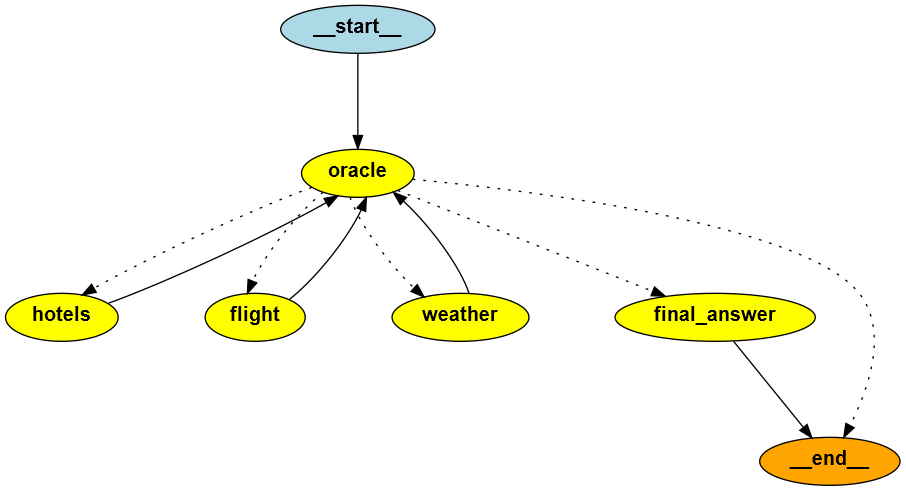

In [22]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [32]:
out = await runnable.run({
    "input": "I want to book a flight from london to paris next thurday",
    "chat_history": [],
})

AttributeError: 'CompiledStateGraph' object has no attribute 'run'

In [ ]:
chunks = []
async for chunk in runnable.stream({"input": "I want to book a flight from london to paris next thurday","chat_history": []})D:
    chunks.append(chunk)
    print(chunk.content, end="|", flush=True)

TypeError: 'generator' object is not subscriptable

In [26]:
out['intermediate_steps']

[AgentAction(tool='flight', tool_input={'departure': 'LHR', 'arrival': 'CDG', 'date': '2024-12-05'}, log='TBD'),
 AgentAction(tool='flight', tool_input={'departure': 'LHR', 'arrival': 'CDG', 'date': '2024-12-05'}, log="[{'numberOfBookableSeats': 9, 'itineraries': [{'duration': 'PT1H20M', 'segments': [{'departure': {'iataCode': 'LHR', 'terminal': '4', 'at': '2024-12-05T11:30:00'}, 'arrival': {'iataCode': 'CDG', 'terminal': '2E', 'at': '2024-12-05T13:50:00'}, 'carrierCode': 'AF', 'number': '1581', 'aircraft': {'code': '223'}, 'operating': {'carrierCode': 'AF'}, 'duration': 'PT1H20M', 'id': '1', 'numberOfStops': 0, 'blacklistedInEU': False}]}], 'price': {'currency': 'EUR', 'total': '130.04', 'base': '64.00', 'fees': [{'amount': '0.00', 'type': 'SUPPLIER'}, {'amount': '0.00', 'type': 'TICKETING'}], 'grandTotal': '130.04', 'additionalServices': [{'amount': '35.00', 'type': 'CHECKED_BAGS'}]}}, {'numberOfBookableSeats': 9, 'itineraries': [{'duration': 'PT1H20M', 'segments': [{'departure': {'i

In [28]:
print(out['intermediate_steps'][-1].tool_input['summary'].split())

['I', 'found', 'several', 'flight', 'options', 'from', 'London', '(LHR)', 'to', 'Paris', '(CDG)', 'for', 'next', 'Thursday.', 'Here', 'are', 'some', 'details:', '-', 'Flight', 'duration', 'is', 'approximately', '1', 'hour', 'and', '20', 'minutes', '-', 'Airlines:', 'Air', 'France', '-', 'Prices', 'range', 'around', '130.04', 'EUR', '-', 'Additional', 'services', 'available', 'for', 'checked', 'bags', 'at', '35.00', 'EUR', '-', 'Different', 'departure', 'times', 'throughout', 'the', 'day:', '11:30,', '14:45,', 'and', '19:35']


In [27]:
print(out['intermediate_steps'][-1].model_dump()['tool_input']['summary'])

I found several flight options from London (LHR) to Paris (CDG) for next Thursday. Here are some details:
- Flight duration is approximately 1 hour and 20 minutes
- Airlines: Air France
- Prices range around 130.04 EUR
- Additional services available for checked bags at 35.00 EUR
- Different departure times throughout the day: 11:30, 14:45, and 19:35


# Explore API

In [ ]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry
import json

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-11-01",
	"end_date": "2023-11-30",
	"daily": ["temperature_2m_max", "temperature_2m_min",'rain_sum','snowfall_sum','wind_speed_10m_max'],
    'wind_speed_unit' : 'mph',
    'temperature_unit': 'fahrenheit'
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]

# Process hourly data. The order of variables needs to be the same as requested.
daily = response.Daily()
temperature_max = float(daily.Variables(0).ValuesAsNumpy().mean())
temperature_min = float(daily.Variables(1).ValuesAsNumpy().mean())
rain_sum = float(daily.Variables(2).ValuesAsNumpy().mean())
snow_sum = float(daily.Variables(3).ValuesAsNumpy().mean())
wind_speed_max = float(daily.Variables(4).ValuesAsNumpy().mean())


# Create a dictionary to hold the data
summary_data = {
    "temperature_max": temperature_max,
    "temperature_min": temperature_min,
    "rain_sum": rain_sum,
    "snow_sum": snow_sum,
    "wind_speed_max": wind_speed_max
}


Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [24]:
import requests
import json


from amadeus import Client, ResponseError
import os
from dotenv import load_dotenv
from tenacity import retry, stop_after_attempt, wait_exponential

# Load variables from the .env file
load_dotenv()



amadeus = Client(
    client_id=os.getenv("AMADEUS_CLIENT_ID"),
    client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
)

# Step 1: Authenticate and get an access token
auth_url = "https://test.api.amadeus.com/v1/security/oauth2/token"

auth_response = requests.post(auth_url, data={
    "grant_type": "client_credentials",
    "client_id": os.getenv("AMADEUS_CLIENT_ID"),
    "client_secret": os.getenv("AMADEUS_CLIENT_SECRET")
})

auth_data = auth_response.json()
access_token = auth_data['access_token']

# Step 2: Perform a transfer search
transfer_search_url = "https://test.api.amadeus.com/v1/shopping/transfer-offers"

headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json"
}

search_payload = {
    "startLocationCode": "MAD",
    # "endAddressLine": "Avenue Anatole France, 5",
    "endCityName": "Paris",
    "endZipCode": "75007",
    # "endCountryCode": "FR",
    # "transferType": "PRIVATE",
    "startDateTime": "2024-12-10T10:30:00",
    # "passengers": 2,
    # "passengerCharacteristics": [
    #     {"passengerTypeCode": "ADT", "age": 30},
    #     {"passengerTypeCode": "CHD", "age": 8}
    # ]
}

response = requests.post(transfer_search_url, headers=headers, json=search_payload)

# Check and display results
if response.status_code == 200:
    print("Transfer Offers:")
    print(json.dumps(response.json(), indent=4))
else:
    print(f"Error: {response.status_code} - {response.text}")


Transfer Offers:
{
    "data": [
        {
            "id": "3661821198",
            "type": "transfer-offer",
            "transferType": "PRIVATE",
            "start": {
                "dateTime": "2025-07-21T11:30:00",
                "address": {
                    "line": "Eiffel Tower, 5 avenue Anatole France",
                    "zip": "75007",
                    "countryCode": "FR",
                    "cityName": "Paris",
                    "stateCode": "FR",
                    "latitude": 48.8586,
                    "longitude": 2.293979
                },
                "googlePlaceId": "googleplaceidgoogleplaceidgoogleplaceid",
                "uicCode": "123456"
            },
            "end": {
                "dateTime": "2025-07-21T12:30:00",
                "address": {
                    "line": "Eiffel Tower, 5 avenue Anatole France",
                    "zip": "75007",
                    "countryCode": "FR",
                    "cityName": "Paris",
  

In [25]:
len(json.loads(response.text)['data'])

1

In [28]:
json.loads(response.text)['data'][0]

{'id': '3661821198',
 'type': 'transfer-offer',
 'transferType': 'PRIVATE',
 'start': {'dateTime': '2025-07-21T11:30:00',
  'address': {'line': 'Eiffel Tower, 5 avenue Anatole France',
   'zip': '75007',
   'countryCode': 'FR',
   'cityName': 'Paris',
   'stateCode': 'FR',
   'latitude': 48.8586,
   'longitude': 2.293979},
  'googlePlaceId': 'googleplaceidgoogleplaceidgoogleplaceid',
  'uicCode': '123456'},
 'end': {'dateTime': '2025-07-21T12:30:00',
  'address': {'line': 'Eiffel Tower, 5 avenue Anatole France',
   'zip': '75007',
   'countryCode': 'FR',
   'cityName': 'Paris',
   'stateCode': 'FR',
   'latitude': 48.8586,
   'longitude': 2.293979},
  'googlePlaceId': 'googleplaceidgoogleplaceidgoogleplaceid',
  'uicCode': '123456'},
 'stopOvers': [{'sequenceNumber': 0,
   'location': {'address': {'line': 'Avenue Marceau, 78bis',
     'zip': '75008',
     'countryCode': 'FR',
     'cityName': 'Paris',
     'stateCode': 'IDF',
     'latitude': 48.8720366,
     'longitude': 2.2970452},
 

In [27]:
json.loads(response.text)['data'][1]

IndexError: list index out of range

# Ollama with tool calling

In [ ]:
['numberOfBookableSeats','itineraries','price','fareDetailsBySegment']

In [88]:
from pydantic import BaseModel

class Rec(BaseModel):
    numberOfBookableSeats: int
    itineraries: list
    price: dict

    def __str__(self):
        """LLM-friendly string representation of the recommendation(s)."""
        return f"Bookabel Seats: {self.numberOfBookableSeats}\nItineraries: {self.itineraries}\nPrice: {self.price}"

In [89]:
# from langchain_core.tools import tool
# from amadeus import Client, ResponseError
# import os
# from dotenv import load_dotenv
# from tenacity import retry, stop_after_attempt, wait_exponential

# # Load variables from the .env file
# load_dotenv()
    
# amadeus = Client(
#     client_id=os.getenv("AMADEUS_CLIENT_ID"),
#     client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
# )

# response = amadeus.shopping.flight_offers_search.get(
#     originLocationCode='LON',
#     destinationLocationCode='PAR',
#     departureDate='2025-01-01',
#     adults=1,
# )

# flights = response.data

# keys_to_filter = ['numberOfBookableSeats','itineraries','price','fareDetailsBySegment']

# filtered_list = [
#     {key: value for key, value in dictionary.items() if key in keys_to_filter}
#     for dictionary in flights
# ]

# filtered_list[0]

In [90]:
@tool
def flight(departure: str, arrival: str, date: str) -> list[Rec]:
    """Find Three letter code for Departure and arrival / find date of trip"""
    
    amadeus = Client(
        client_id=os.getenv("AMADEUS_CLIENT_ID"),
        client_secret=os.getenv("AMADEUS_CLIENT_SECRET"),
    )

    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode=departure,
        destinationLocationCode=arrival,
        departureDate=date,
        adults=1,
    )
    flights = response.data

    keys_to_filter = ['numberOfBookableSeats','itineraries','price']

    filtered_list = [
        {key: value for key, value in dictionary.items() if key in keys_to_filter}
        for dictionary in flights
    ]


    return filtered_list[:3]

In [6]:
import uuid
uuid.uuid4()

UUID('6d304069-031c-44b6-89b6-8e7c97f8f906')